In [1]:
pip install xgboost lightgbm catboost optuna 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 22.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor 
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep10/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep10/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep10/sample_submission.csv'
file_key_4 = 'Tabular-Playground-Series/PS-S3/Ep10/Pulsar.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
# train.drop(columns = 'id', axis = 1, inplace = True)
# train['is_generated'] = 1

test = pd.read_csv(file_content_stream_2)
# test['is_generated'] = 1

submission = pd.read_csv(file_content_stream_3)
original = pd.read_csv(file_content_stream_4)
# original['is_generated'] = 0

# train = pd.concat([train, original], axis = 0)

In [4]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [5]:
original.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

GBC_md = GradientBoostingClassifier(n_estimators = 1000, 
                                    max_depth = 3, 
                                    learning_rate = 0.01,
                                    min_samples_split = 2,
                                    min_samples_leaf = 2).fit(X, Y)

GBC_pred = GBC_md.predict_proba(test_baseline)[:, 1]
submission['Class'] = GBC_pred
submission.head()

,id,Class
0,117564,0.000932
1,117565,0.001962
2,117566,0.001121
3,117567,0.030607
4,117568,0.003653


In [24]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

GBC_md = GradientBoostingClassifier(n_estimators = 1000, 
                                    max_depth = 3, 
                                    learning_rate = 0.01,
                                    min_samples_split = 2,
                                    min_samples_leaf = 2).fit(X, Y)

lgb_md = LGBMClassifier(objective = 'binary',
                        n_estimators = 1000,
                        max_depth = 3,
                        learning_rate = 0.01,
                        num_leaves = 20,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7).fit(X, Y)

xgb_md = XGBClassifier(tree_method = 'hist',
                       colsample_bytree = 0.7, 
                       gamma = 0.8, 
                       learning_rate = 0.01, 
                       max_depth = 7, 
                       min_child_weight = 10, 
                       n_estimators = 1000, 
                       subsample = 0.7).fit(X, Y)

cat_md = CatBoostClassifier(loss_function = 'Logloss',
                            iterations = 1000,
                            learning_rate = 0.01,
                            depth = 7,
                            random_strength = 0.5,
                            bagging_temperature = 0.7,
                            border_count = 30,
                            l2_leaf_reg = 5,
                            verbose = False, 
                            task_type = 'CPU').fit(X, Y)

GBC_pred_train = GBC_md.predict_proba(X)[:, 1]
lgb_pred_train = lgb_md.predict_proba(X)[:, 1]
xgb_pred_train = xgb_md.predict_proba(X)[:, 1]
cat_pred_train = cat_md.predict_proba(X)[:, 1]

GBC_pred = GBC_md.predict_proba(test_baseline)[:, 1]
lgb_pred = lgb_md.predict_proba(test_baseline)[:, 1]
xgb_pred = xgb_md.predict_proba(test_baseline)[:, 1]
cat_pred = cat_md.predict_proba(test_baseline)[:, 1]

isor = IsotonicRegression(out_of_bounds = 'clip').fit(GBC_pred_train, Y)
GBC_pred_calibrated = isor.predict(GBC_pred)

isor = IsotonicRegression(out_of_bounds = 'clip').fit(lgb_pred_train, Y)
lgb_pred_calibrated = isor.predict(lgb_pred)

isor = IsotonicRegression(out_of_bounds = 'clip').fit(xgb_pred_train, Y)
xgb_pred_calibrated = isor.predict(xgb_pred)

isor = IsotonicRegression(out_of_bounds = 'clip').fit(cat_pred_train, Y)
cat_pred_calibrated = isor.predict(lgb_pred)

ens_preds = 0.01*GBC_pred_calibrated + 0.34*lgb_pred_calibrated + 0.3*xgb_pred_calibrated + 0.35*cat_pred_calibrated
submission['Class'] = ens_preds
submission.head()

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,id,Class
0,117564,0.000077
1,117565,0.000483
2,117566,0.000169
3,117567,0.053104
4,117568,0.001546


In [30]:
ens_preds = 0.15*GBC_pred_calibrated + 0.2*lgb_pred_calibrated + 0.3*xgb_pred_calibrated + 0.35*cat_pred_calibrated
submission['Class'] = ens_preds
submission.head()

,id,Class
0,117564,0.000100
1,117565,0.000483
2,117566,0.000169
3,117567,0.052751
4,117568,0.001860


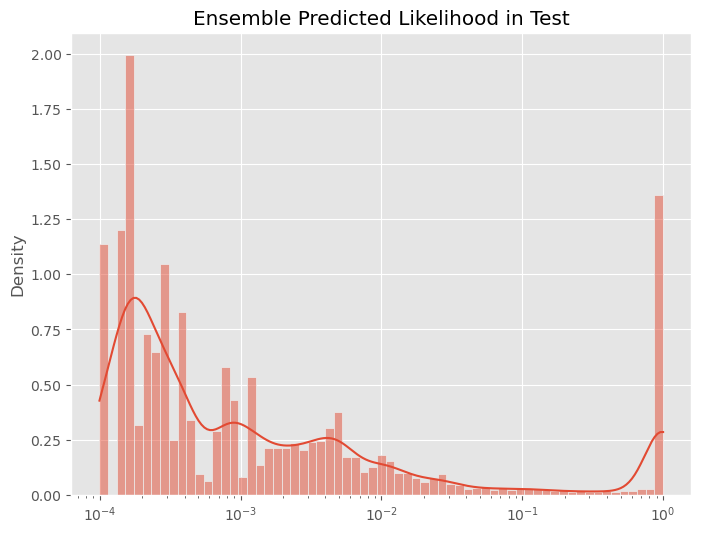

In [31]:
plt.figure(figsize = (8, 6))
sns.histplot(data = ens_preds, kde = True, stat = 'density', log_scale = True).set(title = 'Ensemble Predicted Likelihood in Test');

In [32]:
submission.to_csv('Ensemble_Baseline_full_submission_10.csv', index = False)

In [22]:
isor = IsotonicRegression(out_of_bounds = 'clip').fit(GBC_pred_train, Y)
GBC_pred_calibrated = isor.predict(GBC_pred)

isor = IsotonicRegression(out_of_bounds = 'clip').fit(lgb_pred_train, Y)
lgb_pred_calibrated = isor.predict(lgb_pred)

isor = IsotonicRegression(out_of_bounds = 'clip').fit(xgb_pred_train, Y)
xgb_pred_calibrated = isor.predict(xgb_pred)

isor = IsotonicRegression(out_of_bounds = 'clip').fit(cat_pred_train, Y)
cat_pred_calibrated = isor.predict(lgb_pred)

In [19]:
GBC_pred

array([9.21147079e-04, 1.98306188e-03, 1.12426229e-03, ...,
       9.21147079e-04, 3.31948070e-02, 9.81942141e-01])

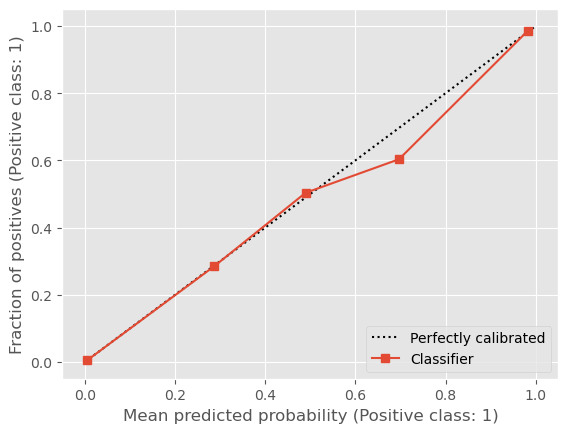

In [20]:
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(Y, GBC_pred_train);

isor = IsotonicRegression(out_of_bounds = 'clip').fit(GBC_pred_train, Y)
GBC_pred_calibrated = isor.predict(GBC_pred)

In [21]:
GBC_pred_calibrated

array([1.60307791e-04, 4.55097087e-04, 1.60307791e-04, ...,
       1.60307791e-04, 3.39869281e-02, 9.89411765e-01])

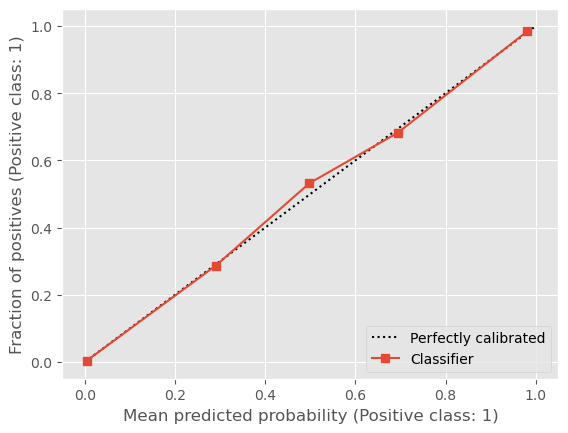

In [13]:
CalibrationDisplay.from_predictions(Y, lgb_pred_train);

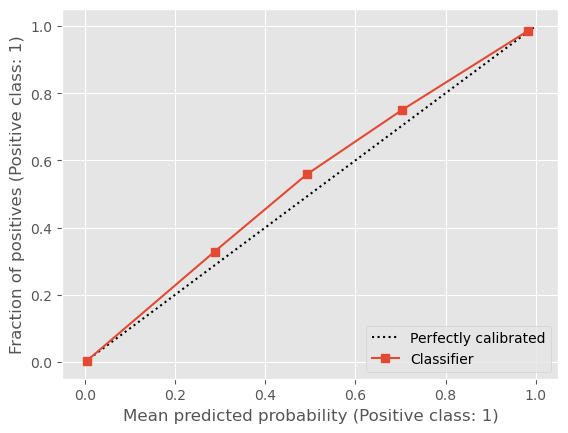

In [15]:
CalibrationDisplay.from_predictions(Y, xgb_pred_train);

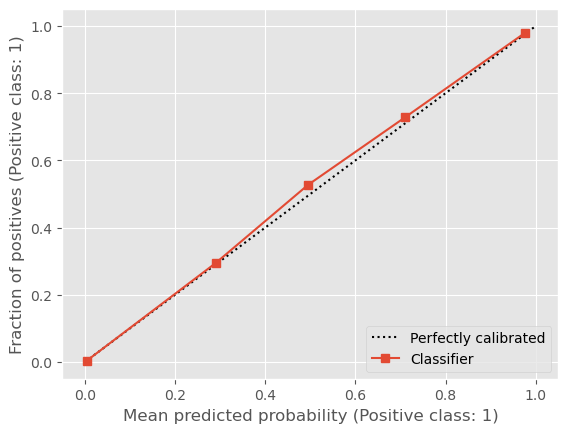

In [16]:
CalibrationDisplay.from_predictions(Y, cat_pred_train);

In [8]:
test_baseline.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,140.046875,54.507800,0.058862,-0.567263,2.337793,14.868335,9.591760,117.988781
1,107.828125,51.578965,0.284368,-0.338430,1.574415,12.501437,11.694968,182.704822
2,135.062500,49.812343,-0.087784,-0.094341,3.576923,21.243336,7.252386,59.021499
3,112.812500,41.926647,0.519921,1.287762,6.669732,29.013153,5.097661,27.105240
4,96.210938,35.322620,0.481286,2.443080,2.218227,17.041064,9.766006,117.131775


In [13]:
ens_preds = (GBC_pred + lgb_pred + xgb_pred + cat_pred) / 4
submission['Class'] = ens_preds
submission.head()

,id,Class
0,117564,0.000434
1,117565,0.001724
2,117566,0.000556
3,117567,0.069054
4,117568,0.004013


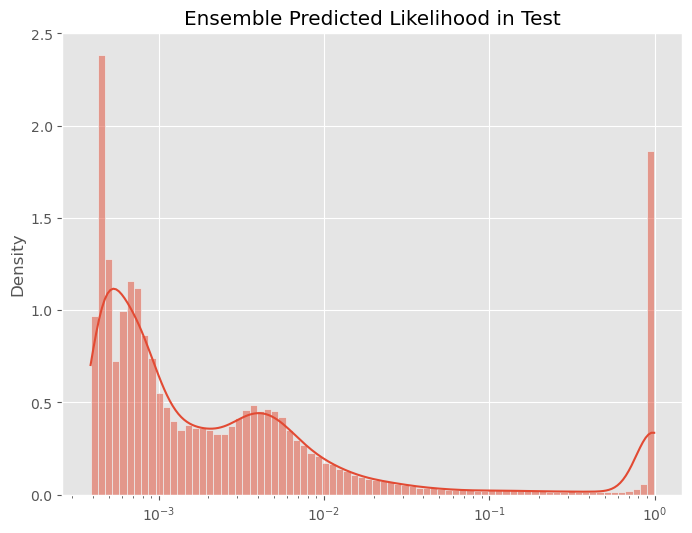

In [14]:
plt.figure(figsize = (8, 6))
sns.histplot(data = ens_preds, kde = True, stat = 'density', log_scale = True).set(title = 'Ensemble Predicted Likelihood in Test');

In [15]:
submission.to_csv('Ensemble_Baseline_full_submission_7.csv', index = False)

# GAM

In [2]:
pip install pygam

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from pygam import LogisticGAM, s, f, te

# from lightgbm import LGBMClassifier, LGBMRegressor 
# from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor

# import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep10/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep10/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep10/sample_submission.csv'
file_key_4 = 'Tabular-Playground-Series/PS-S3/Ep10/Pulsar.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
# train.drop(columns = 'id', axis = 1, inplace = True)
# train['is_generated'] = 1

test = pd.read_csv(file_content_stream_2)
# test['is_generated'] = 1

submission = pd.read_csv(file_content_stream_3)
original = pd.read_csv(file_content_stream_4)
# original['is_generated'] = 0

# train = pd.concat([train, original], axis = 0)

In [7]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [8]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
X.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765


In [44]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']

test_baseline = test.drop(columns = ['id'], axis = 1)

cv_scores, log_loss_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    ## Splitting the data 
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    ## Building the GAM model
#     gam_md = LogisticGAM(s(0) +
#                          s(1) +
#                          s(2) +
#                          s(3) +
#                          s(4) +
#                          s(5) +
#                          s(6) +
#                          s(7) +
#                          te(2, 6) +
#                          te(1, 5) +
#                          te(3, 7)).fit(X_train, Y_train)
    gam_md = LogisticGAM(s(0, n_splines = 20) +
                         s(1) +
                         s(2, n_splines = 30) +
                         s(3) +
                         s(4) +
                         s(5) +
                         s(6) +
                         s(7) + 
                         te(2, 6) +
                         te(1, 5)).fit(X_train, Y_train)

    ## Predicting on X_test and test
    gam_pred_1 = gam_md.predict_proba(X_test)
    gam_pred_2 = gam_md.predict_proba(test_baseline)
    
    log_loss_scores.append(log_loss(Y_test, gam_pred_1))
    preds.append(gam_pred_2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pygam/pygam.py:752: RuntimeWarning: divide by zero encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pygam/pygam.py:752: RuntimeWarning: divide by zero encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/home/ec2-user/anaco

In [20]:
np.mean(log_loss_scores)

0.032662114444624

In [22]:
np.mean(log_loss_scores)

0.032629624669720594

In [24]:
np.mean(log_loss_scores)

0.03296800269287657

In [26]:
np.mean(log_loss_scores)

0.03168510181995954

In [29]:
np.mean(log_loss_scores)

0.03166566715700558

In [38]:
np.mean(log_loss_scores)

0.03166566715700558

In [40]:
np.mean(log_loss_scores)

0.03165724499582471

In [45]:
np.mean(log_loss_scores)

0.03165724499582471

In [46]:
ens_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['Class'] = ens_preds_test
submission.head()

,id,Class
0,117564,0.000066
1,117565,0.000762
2,117566,0.000080
3,117567,0.041975
4,117568,0.001889


In [47]:
submission.to_csv('GAM_Baseline_submission.csv', index = False)